In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import time

sys.path.append("../../../XRaySimulation2")

from XRaySimulation import util

In [2]:
def get_reflectivity(rock_th_scan,
                     g_vec_c,
                     n_vec_c,
                     t_vec_c,
                     kin_vec_c,
                     phonon_field_amplitude=1e-3,
                     g_angle_fwhm=np.deg2rad(3e-3), g_angle_num=16,
                     phonon_q_fwhm=0, phonon_q_num=1,
                     x_energy_fwhm=0, x_energy_num=1,
                     x_angle_fwhm=0, x_angle_num=1,
                     crystal_property=None):
    rock_th_num = rock_th_scan.shape[0]
    total_entry_num = g_angle_num * phonon_q_num * x_angle_num * x_energy_num * rock_th_num

    x_energy_sigma = util.intensity_fwhm_to_field_sigma(fwhm=x_energy_fwhm)
    x_angle_sigma = util.intensity_fwhm_to_field_sigma(fwhm=x_angle_fwhm)
    phonon_q_sigma = util.intensity_fwhm_to_field_sigma(fwhm=phonon_q_fwhm)
    g_angle_sigma = util.intensity_fwhm_to_field_sigma(fwhm=g_angle_fwhm)

    # Create holder and assign the central value
    k_array = np.reshape(np.outer(np.ones(total_entry_num), kin_vec_c),
                         newshape=(g_angle_num, phonon_q_num, x_angle_num, x_energy_num, rock_th_num, 3))
    g_array = np.reshape(np.outer(np.ones(total_entry_num), g_vec_c),
                         newshape=(g_angle_num, phonon_q_num, x_angle_num, x_energy_num, rock_th_num, 3))
    n_array = np.reshape(np.outer(np.ones(total_entry_num), n_vec_c),
                         newshape=(g_angle_num, phonon_q_num, x_angle_num, x_energy_num, rock_th_num, 3))
    phonon_q_array = np.reshape(np.outer(np.ones(total_entry_num), t_vec_c),
                                newshape=(g_angle_num, phonon_q_num, x_angle_num, x_energy_num, rock_th_num, 3))
    phonon_p_array = np.reshape(np.outer(np.ones(total_entry_num), t_vec_c / np.linalg.norm(t_vec_c)),
                                newshape=(g_angle_num, phonon_q_num, x_angle_num, x_energy_num, rock_th_num, 3))
    phonon_omega_array = np.ones((g_angle_num, phonon_q_num, x_angle_num, x_energy_num, rock_th_num),
                                 dtype=np.float64) * 0.75e-3  # 0.5 THz phonon

    # Assign the scan value
    if x_energy_num > 1:
        x_energy_scan = np.linspace(start=-x_energy_fwhm * 2., stop=x_energy_fwhm * 2., num=x_energy_num)
        x_energy_field = (np.exp(- x_energy_scan ** 2 / 2. / x_energy_sigma ** 2) /
                          np.power(np.pi * x_energy_sigma ** 2, 0.25))
        scaling = util.kev_to_wavevec_length(x_energy_scan) / np.linalg.norm(kin_vec_c) + 1
        k_array *= scaling[np.newaxis, np.newaxis, np.newaxis, :, np.newaxis, np.newaxis]

    if x_angle_num > 1:
        x_angle_scan = np.linspace(start=-x_angle_fwhm * 2., stop=x_angle_fwhm * 2., num=x_angle_num)
        x_angle_field = (np.exp(- x_angle_scan ** 2 / 2. / x_angle_sigma ** 2) /
                         np.power(np.pi * x_angle_sigma ** 2, 0.25))
        for idx in range(x_angle_num):
            diverg_mat = util.get_rotmat_around_axis(angleRadian=x_angle_scan[idx],
                                                     axis=np.array([-1., 1., 0.]) / np.sqrt(2))
            k_array[:, :, idx, :, :, :] = np.dot(k_array[:, :, idx, :, :, :], diverg_mat.T)

    if phonon_q_num > 1:
        phonon_q_scan = np.linspace(start=-phonon_q_fwhm * 2., stop=phonon_q_fwhm * 2., num=phonon_q_num)
        phonon_field = (np.exp(- phonon_q_scan ** 2 / 2. / phonon_q_sigma ** 2) /
                        np.power(np.pi * phonon_q_sigma ** 2, 0.25))

        phonon_field *= np.sqrt(phonon_field_amplitude)

        phonon_q_array[:, :, :, :, :, 0] += phonon_q_scan[np.newaxis, :, np.newaxis, np.newaxis, np.newaxis]
        phonon_p_array[:, :, :, :, :, 0] *= phonon_field[np.newaxis, :, np.newaxis, np.newaxis, np.newaxis]
        phonon_p_array[:, :, :, :, :, 0] *= phonon_q_scan[1] - phonon_q_scan[0]

        #return phonon_field
        print("With this phonon field, the maximal displacement is {} nm".format(
            1000 * np.sum(phonon_field) * (phonon_q_scan[1] - phonon_q_scan[0])))
        print("With this phonon field, the STD displacement is {} nm".format(
            1000 * np.sum(phonon_field ** 2) * (phonon_q_scan[1] - phonon_q_scan[0])))

    if g_angle_num > 1:
        g_angle_scan = np.linspace(start=-g_angle_fwhm * 2., stop=g_angle_fwhm * 2., num=g_angle_num)
        g_angle_field = (np.exp(- g_angle_scan ** 2 / 2. / g_angle_sigma ** 2) /
                         np.power(np.pi * g_angle_sigma ** 2, 0.25))
        for idx in range(g_angle_num):
            diverg_mat = util.get_rotmat_around_axis(angleRadian=g_angle_scan[idx],
                                                     axis=np.array([-1., 1., 0.]) / np.sqrt(2))
            g_array[idx, :, :, :, :, :] = np.dot(g_array[idx, :, :, :, :, :], diverg_mat.T)

    #print(g_array)

    # scan the sample rotation 
    tilt_angle = np.deg2rad(11.5)
    tilt_mat = util.get_rotmat_around_axis(angleRadian=tilt_angle, axis=np.array([0, 1., 0.]))

    for idx in range(rock_th_scan.shape[0]):
        rot_mat = util.get_rotmat_around_axis(angleRadian=rock_th_scan[idx], axis=np.array([1., 0., 0.]))
        g_array[:, :, :, :, idx, :] = np.dot(np.dot(g_array[:, :, :, :, idx, :], rot_mat.T), tilt_mat.T)
    # Calculate the reflectivity
    (R0H, R00, b,
     d_plus, d_minus,
     kout, delta_chih) = util.get_bragg_reflectivity_with_phonon(
        kVec=np.reshape(k_array, newshape=(total_entry_num, 3)),
        thickness=500.,  # um
        BraggG=np.reshape(g_array, newshape=(total_entry_num, 3)),
        normal=np.reshape(n_array, newshape=(total_entry_num, 3)),
        phononQ=np.reshape(phonon_q_array, newshape=(total_entry_num, 3)),
        omega=np.reshape(phonon_omega_array, newshape=total_entry_num),
        polar=np.reshape(phonon_p_array, newshape=(total_entry_num, 3)),
        chi0=crystal_property['chi0'],
        chih=crystal_property['chih'],
        chihbar=crystal_property['chih'], )

    # Get the averaged quantity as a function of rocking th
    reflectivity_plus = np.reshape(np.copy(d_plus),
                                   newshape=(g_angle_num, phonon_q_num, x_angle_num, x_energy_num, rock_th_num))
    reflectivity_minus = np.reshape(np.copy(d_minus),
                                    newshape=(g_angle_num, phonon_q_num, x_angle_num, x_energy_num, rock_th_num))
    reflectivity = np.reshape(np.copy(R0H),
                              newshape=(g_angle_num, phonon_q_num, x_angle_num, x_energy_num, rock_th_num))
    b = np.reshape(b, newshape=(g_angle_num, phonon_q_num, x_angle_num, x_energy_num, rock_th_num))

    delta_chih = np.reshape(delta_chih, newshape=(g_angle_num, phonon_q_num, x_angle_num, x_energy_num, rock_th_num))
    # kout = np.reshape(kout, newshape=(g_angle_num, phonon_q_num, x_angle_num, x_energy_num, rock_th_num, 3))

    delta_chih_mean = np.copy(delta_chih)

    # Average over each level:
    if phonon_q_num > 1:  # Remove the phonon q dependence since this is a coherent contribution
        reflectivity = np.sum(reflectivity, axis=1) / phonon_q_num
        reflectivity_plus = np.sum(reflectivity_plus, axis=1)
        reflectivity_minus = np.sum(reflectivity_minus, axis=1)
        b = np.sum(b, axis=1)

        delta_chih_mean = np.sum(delta_chih_mean, axis=1)

    if g_angle_num > 1:
        reflectivity = (np.multiply(
            reflectivity,
            g_angle_field[:, np.newaxis, np.newaxis, np.newaxis].astype(np.complex128))
                        * np.sqrt(g_angle_scan[1] - g_angle_scan[0]))
        reflectivity_plus = (np.multiply(
            reflectivity_plus,
            g_angle_field[:, np.newaxis, np.newaxis, np.newaxis].astype(np.complex128))
                             * np.sqrt(g_angle_scan[1] - g_angle_scan[0]))
        reflectivity_minus = (np.multiply(
            reflectivity_minus,
            g_angle_field[:, np.newaxis, np.newaxis, np.newaxis].astype(np.complex128))
                              * np.sqrt(g_angle_scan[1] - g_angle_scan[0]))
        delta_chih_mean = (np.multiply(
            delta_chih_mean,
            g_angle_field[:, np.newaxis, np.newaxis, np.newaxis].astype(np.complex128) ** 2)
                           * (g_angle_scan[1] - g_angle_scan[0]))
        delta_chih_mean = np.sum(delta_chih_mean, axis=0)

    if x_energy_num > 1:
        reflectivity = (np.multiply(
            reflectivity,
            x_energy_field[np.newaxis, np.newaxis, :, np.newaxis].astype(np.complex128))
                        * np.sqrt(x_energy_scan[1] - x_energy_scan[0]))
        reflectivity_plus = (np.multiply(
            reflectivity_plus,
            x_energy_field[np.newaxis, np.newaxis, :, np.newaxis].astype(np.complex128))
                             * np.sqrt(x_energy_scan[1] - x_energy_scan[0]))
        reflectivity_minus = (np.multiply(
            reflectivity_minus,
            x_energy_field[np.newaxis, np.newaxis, :, np.newaxis].astype(np.complex128))
                              * np.sqrt(x_energy_scan[1] - x_energy_scan[0]))

    if x_angle_num > 1:
        reflectivity = (np.multiply(
            reflectivity,
            x_angle_field[np.newaxis, :, np.newaxis, np.newaxis].astype(np.complex128))
                        * np.sqrt(x_angle_scan[1] - x_angle_scan[0]))
        reflectivity_plus = (np.multiply(
            reflectivity_plus,
            x_angle_field[np.newaxis, :, np.newaxis, np.newaxis].astype(np.complex128))
                             * np.sqrt(x_angle_scan[1] - x_angle_scan[0]))
        reflectivity_minus = (np.multiply(
            reflectivity_minus,
            x_angle_field[np.newaxis, :, np.newaxis, np.newaxis].astype(np.complex128))
                              * np.sqrt(x_angle_scan[1] - x_angle_scan[0]))

    # Perform the averaging calculation
    #reflectivity = np.sum(np.square(np.abs(reflectivity)) / np.abs(b), axis=-1)
    #reflectivity_plus = np.sum(np.square(np.abs(reflectivity_plus)) / np.abs(b), axis=-1)
    #reflectivity_minus = np.sum(np.square(np.abs(reflectivity_minus)) / np.abs(b), axis=-1)

    reflectivity_total = np.sum(np.square(np.abs(reflectivity
                                                 + reflectivity_plus + reflectivity_minus)) / np.abs(b),
                                axis=(0, 1, 2))
    reflectivity_tg = np.sum(np.square(np.abs(reflectivity_plus + reflectivity_minus)) / np.abs(b),
                             axis=(0, 1, 2))
    delta_chih_mean = np.mean(delta_chih_mean, axis=(0, 1))

    return reflectivity_total, reflectivity_tg, {'delta chi_h': delta_chih,
                                                 'delta chi_h mean': delta_chih_mean,
                                                 "R0H": reflectivity,
                                                 "R00": R00,
                                                 "b": b,
                                                 "d_plus": reflectivity_plus,
                                                 "d_minus": reflectivity_minus,
                                                 "omega": phonon_omega_array,
                                                 }


In [3]:
# unit system:
#  um, fs, keV, (x,y,z) = (horizontal, vertical, downstream of X-ray) or the convention at XPP.

Ec = 9.8  # keV
klen = util.kev_to_wavevec_length(Ec)  # 2pi/wavelength in um^-1

# Get the k_in
wedge_angle = np.deg2rad(10)
rot_mat = util.get_rotmat_around_axis(angleRadian=np.deg2rad(3.575 * 2),
                                      axis=np.array([0, np.sin(wedge_angle), -np.cos(wedge_angle)]))
si111_angle = np.deg2rad(2 * 11.639 - 0.2)
# incident wave-vector, or kin  # 2 pi / wavelength
k_vec = np.dot(rot_mat, np.array([0, - np.sin(si111_angle), np.cos(si111_angle), ]) * klen)  

# Get the STO 220 crystal property used for dynamical diffraction theory
crystal_property = {"d": 1.3806 * 1e-4,  # um
                    "chi0": complex(-0.20135E-04, 0.63853E-06),
                    "chih": complex(0.10376E-04, -0.60756E-06),
                    "chih_pi": complex(0.60195E-05, -0.35235E-06), }

# Get the reciprocal lattice
tilt_angle = np.deg2rad(11.5)
tilt_mat = util.get_rotmat_around_axis(angleRadian=tilt_angle, axis=np.array([0, 1., 0.]))

#g_vec = np.dot(tilt_mat, np.array([1, 1, 0]) / np.sqrt(2) * np.pi * 2 / crystal_property['d'])
# !!: This is not the direction of the reciprocal lattice. I have to rotate it to get the reciprocal lattice.
g_vec = np.array([1, 1, 0]) / np.sqrt(2) * np.pi * 2 / crystal_property['d']

# Get the crystal normal direction
normal_vec = np.array([- np.cos(tilt_angle), 0, np.sin(tilt_angle)])

# Get the TG vector
tg_angle = np.deg2rad(0.1567 * 2 - 7e-3)
t_vec = np.array([1, 0, 0]) * klen * np.sin(tg_angle) * 2.

# This is the reciprocal lattice:
print("This is the reciprocal lattice when I have the phase matching condition for the TG:")
print(g)

In [ ]:

# phonon field amplitude
phonon_field_amplitude = 1e-3 * 2.4997e-04

# Quick demonstration of all peaks

With this phonon field, the maximal displacement is 0.009767593480901221 nm
With this phonon field, the STD displacement is 0.00046967660606821567 nm


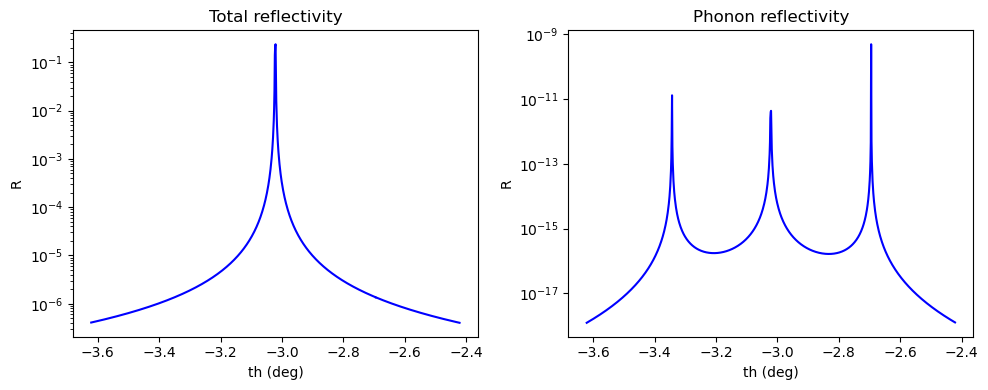

In [4]:
# Span the angle and energy range
num = 2 ** 10  # Number of points to calculate
rock_angle_bragg = np.linspace(start=np.deg2rad(-3.0213 - 0.6), stop=np.deg2rad(-3.0213 + 0.6), num=num)

(reflectivity_tot,
 reflectivity_phonon,
 raw_data) = get_reflectivity(rock_th_scan=rock_angle_bragg, g_vec_c=np.copy(g_vec),
                              n_vec_c=np.copy(normal_vec), t_vec_c=np.copy(t_vec),
                              kin_vec_c=np.copy(k_vec),
                              phonon_field_amplitude=phonon_field_amplitude,
                              g_angle_fwhm=np.deg2rad(3e-6),
                              g_angle_num=4,
                              phonon_q_fwhm=1e-4,
                              phonon_q_num=3,
                              x_energy_fwhm=1e-6,
                              x_energy_num=6,
                              x_angle_fwhm=1e-6,
                              x_angle_num=5,
                              crystal_property=crystal_property)

fig, axes = plt.subplots(ncols=2, nrows=1)
fig.set_figwidth(10)
fig.set_figheight(4)

axes[0].semilogy(np.rad2deg(rock_angle_bragg), reflectivity_tot, color='b', linestyle="-")
axes[0].set_title("Total reflectivity")
axes[0].set_ylabel("R")
axes[0].set_xlabel("th (deg)")

axes[1].semilogy(np.rad2deg(rock_angle_bragg), reflectivity_phonon, color='b', linestyle="-")
axes[1].set_title("Phonon reflectivity")
axes[1].set_ylabel("R")
axes[1].set_xlabel("th (deg)")

plt.tight_layout()
plt.show()

The FWHM from gaussian fit of STO 220 is 0.008443914879745508
The FWHM from gaussian fit of 12 nm TG is 0.013049692401656066


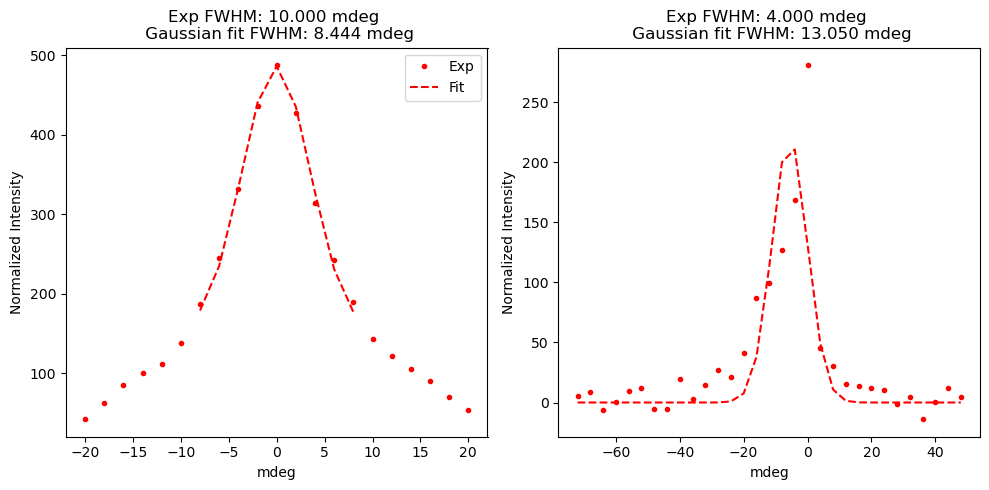

In [5]:
# Load the STO 220 Bragg peak measruement
intensity_bragg = np.load('./rocking_sto220.npy')[0]

th_bragg = np.load('./sam_th_sto220.npy')
th_bragg -= th_bragg[np.argmax(intensity_bragg)]

fwhm_exp_bragg = util.get_fwhm(coordinate=th_bragg, curve_values=intensity_bragg)

intensity_bragg_tmp = np.copy(intensity_bragg) - 150
intensity_bragg_tmp[intensity_bragg_tmp < 0] = 0

bragg_fit, bragg_fit_std = util.get_gaussian_fit(coordinate=np.array(th_bragg), curve=intensity_bragg_tmp)
print("The FWHM from gaussian fit of STO 220 is {}".format(util.sigma_to_fwhm(bragg_fit_std)))

# Load the 12 nm TG Bragg peak measurement
intensity_12nm = np.load("12nm_rocking_I.npy")

th_12nm = np.load("12nm_rocking_theta.npy")
th_12nm -= th_12nm[np.argmax(intensity_12nm)]

fwhm_exp_12nm = util.get_fwhm(coordinate=th_12nm, curve_values=intensity_12nm)

intensity_12nm_tmp = np.copy(intensity_12nm)
intensity_12nm_tmp[intensity_12nm_tmp < 60] = 0

# Get the sigma
tg_fit_12nm, tg_fit_std_12nm = util.get_gaussian_fit(coordinate=th_12nm, curve=intensity_12nm_tmp)
print("The FWHM from gaussian fit of 12 nm TG is {}".format(util.sigma_to_fwhm(tg_fit_std_12nm)))

# ------------------------------------------
fig, axes = plt.subplots(ncols=2, nrows=1)
fig.set_figwidth(10)
fig.set_figheight(5)

axes[0].plot(th_bragg * 1000, intensity_bragg, marker='.', linestyle='', color='r', label='Exp')
axes[0].plot(th_bragg[6:-6] * 1000, bragg_fit[6:-6] + 150, marker='', linestyle='--', color='r', label='Fit')
axes[0].set_ylabel('Normalized Intensity')
axes[0].set_xlabel("mdeg")
axes[0].set_title("Exp FWHM: {:.3f} mdeg \n Gaussian fit FWHM: {:.3f} mdeg".format(fwhm_exp_bragg * 1000,
                                                                                   util.sigma_to_fwhm(
                                                                                       bragg_fit_std) * 1000))
axes[0].legend()

axes[1].plot(th_12nm * 1000, intensity_12nm, marker='.', linestyle='', color='r', label='Exp')
axes[1].plot(th_12nm * 1000, tg_fit_12nm, marker='', linestyle='--', color='r', label='Fit')
axes[1].set_ylabel('Normalized Intensity')
axes[1].set_xlabel("mdeg")
axes[1].set_title("Exp FWHM: {:.3f} mdeg \n Gaussian fit FWHM: {:.3f} mdeg".format(fwhm_exp_12nm * 1000,
                                                                                   util.sigma_to_fwhm(
                                                                                       tg_fit_std_12nm) * 1000))

plt.tight_layout()
plt.show()

In [6]:
# In this case, the relative diffraction efficiency is:
relative_efficiency = 1.8952234826281729 / np.max(intensity_bragg) / 1e4
print("The relative diffraction efficiency is {:.2e}".format(relative_efficiency))

The relative diffraction efficiency is 3.89e-07


# Get the central Bragg peak

In [7]:
# Span the angle and energy range
num = 2 ** 6  # Number of points to calculate
rock_angle_bragg = np.linspace(start=np.deg2rad(-3.0213 - 0.02), stop=np.deg2rad(-3.0213 + 0.02), num=num)

(reflectivity_tot_bragg,
 reflectivity_phonon_bragg,
 raw_data_bragg) = get_reflectivity(rock_th_scan=rock_angle_bragg,
                                    g_vec_c=np.copy(g_vec),
                                    n_vec_c=np.copy(normal_vec),
                                    t_vec_c=np.copy(t_vec),
                                    kin_vec_c=np.copy(k_vec),
                                    phonon_field_amplitude=phonon_field_amplitude,
                                    g_angle_fwhm=np.deg2rad(7e-3),
                                    g_angle_num=32,
                                    phonon_q_fwhm=t_vec[0] / 157,
                                    phonon_q_num=16,
                                    x_energy_fwhm=0.3e-3,
                                    x_energy_num=16,
                                    x_angle_fwhm=14e-6,
                                    x_angle_num=16,
                                    crystal_property=crystal_property)

With this phonon field, the maximal displacement is 1.3413544238407207 nm
With this phonon field, the STD displacement is 0.0002499699160918381 nm


In [8]:
fwhm_theory_bragg = util.get_fwhm(coordinate=np.rad2deg(rock_angle_bragg), curve_values=reflectivity_tot_bragg)


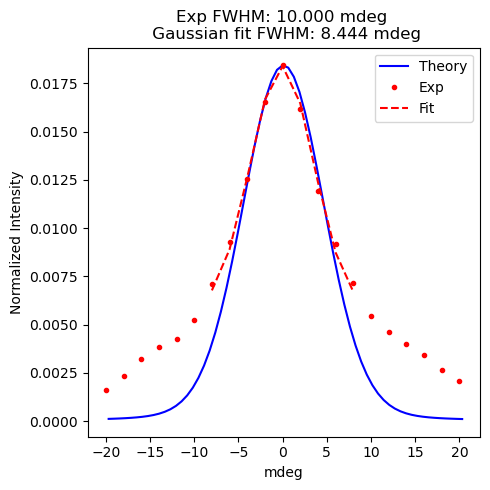

In [9]:
fig, axes = plt.subplots(ncols=1, nrows=1)
fig.set_figwidth(5)
fig.set_figheight(5)

axes.plot(np.rad2deg(rock_angle_bragg - rock_angle_bragg[np.argmax(reflectivity_tot_bragg)]) * 1000,
          reflectivity_tot_bragg, color='b', linestyle="-", label='Theory')
axes.set_title("Total reflectivity")
axes.set_ylabel("R")
axes.set_xlabel("th (deg)")

scaling = 1. / np.max(intensity_bragg) * np.max(reflectivity_tot_bragg)

axes.plot(th_bragg * 1000, intensity_bragg * scaling,
          marker='.', linestyle='', color='r', label='Exp')
axes.plot(th_bragg[6:-6] * 1000, (bragg_fit[6:-6] + 150) * scaling, marker='', linestyle='--', color='r', label='Fit')
axes.set_ylabel('Normalized Intensity')
axes.set_xlabel("mdeg")
axes.set_title("Exp FWHM: {:.3f} mdeg \n Gaussian fit FWHM: {:.3f} mdeg".format(fwhm_exp_bragg * 1000,
                                                                                util.sigma_to_fwhm(
                                                                                    bragg_fit_std) * 1000))
axes.legend()

plt.tight_layout()
plt.show()

In [10]:
# Span the angle and energy range
num = 2 ** 6  # Number of points to calculate
rock_angle_tg = np.linspace(start=np.deg2rad(-3.4), stop=np.deg2rad(-3.28), num=num)

(reflectivity_tot_tg,
 reflectivity_phonon_tg,
 raw_data_tg) = get_reflectivity(rock_th_scan=rock_angle_tg,
                                 g_vec_c=np.copy(g_vec),
                                 n_vec_c=np.copy(normal_vec),
                                 t_vec_c=np.copy(t_vec),
                                 kin_vec_c=np.copy(k_vec),
                                 phonon_field_amplitude=phonon_field_amplitude,
                                 g_angle_fwhm=np.deg2rad(7e-3),
                                 g_angle_num=32,
                                 phonon_q_fwhm=t_vec[0] / 157,
                                 phonon_q_num=16,
                                 x_energy_fwhm=0.3e-3,
                                 x_energy_num=16,
                                 x_angle_fwhm=14e-6,
                                 x_angle_num=16,
                                 crystal_property=crystal_property)

With this phonon field, the maximal displacement is 1.3413544238407207 nm
With this phonon field, the STD displacement is 0.0002499699160918381 nm


In [11]:
fwhm_theory_12nm = util.get_fwhm(coordinate=np.rad2deg(rock_angle_tg), curve_values=reflectivity_phonon_tg)

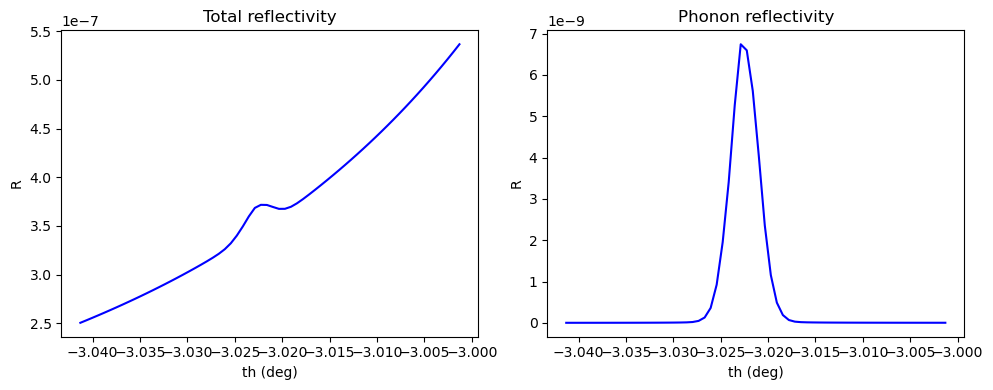

In [12]:
fig, axes = plt.subplots(ncols=2, nrows=1)
fig.set_figwidth(10)
fig.set_figheight(4)

axes[0].plot(np.rad2deg(rock_angle_bragg), reflectivity_tot_tg, color='b', linestyle="-")
axes[0].set_title("Total reflectivity")
axes[0].set_ylabel("R")
axes[0].set_xlabel("th (deg)")

axes[1].plot(np.rad2deg(rock_angle_bragg), reflectivity_phonon_tg, color='b', linestyle="-")
axes[1].set_title("Phonon reflectivity")
axes[1].set_ylabel("R")
axes[1].set_xlabel("th (deg)")

plt.tight_layout()
plt.show()

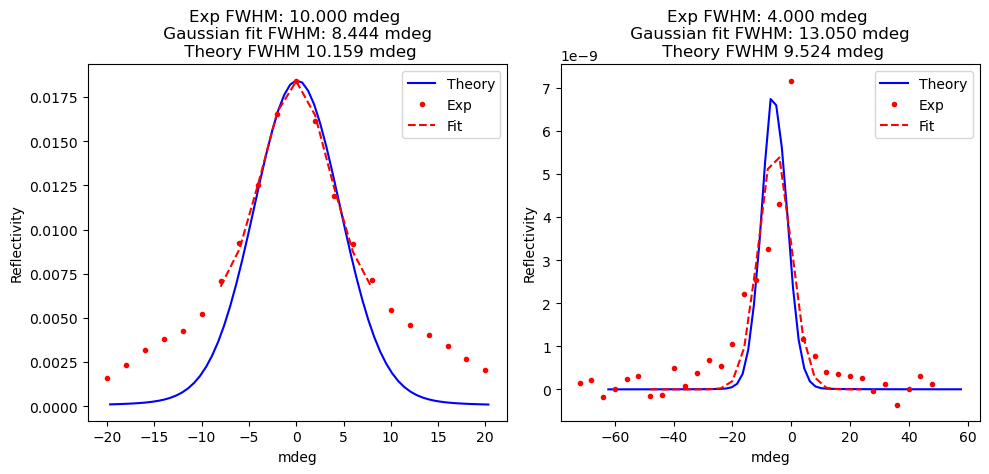

In [13]:
fig, axes = plt.subplots(ncols=2, nrows=1)
fig.set_figwidth(10)
fig.set_figheight(5)

# ------------------------------------------------------------
axes[0].plot(np.rad2deg(rock_angle_bragg - rock_angle_bragg[np.argmax(reflectivity_tot_bragg)]) * 1000,
             reflectivity_tot_bragg, color='b', linestyle="-", label='Theory')

scaling = 1. / np.max(intensity_bragg) * np.max(reflectivity_tot_bragg)

axes[0].plot(th_bragg * 1000, intensity_bragg * scaling,
             marker='.', linestyle='', color='r', label='Exp')
axes[0].plot(th_bragg[6:-6] * 1000, (bragg_fit[6:-6] + 150) * scaling, marker='', linestyle='--', color='r',
             label='Fit')
axes[0].set_ylabel('Reflectivity')
axes[0].set_xlabel("mdeg")
axes[0].set_title(
    "Exp FWHM: {:.3f} mdeg \n Gaussian fit FWHM: {:.3f} mdeg \n Theory FWHM {:.3f} mdeg".format(fwhm_exp_bragg * 1000,
                                                                                                util.sigma_to_fwhm(
                                                                                                    bragg_fit_std) * 1000,
                                                                                                fwhm_theory_bragg * 1000))
axes[0].legend()

# ---------------------------------------------------------------
axes[1].plot(np.rad2deg(rock_angle_tg - rock_angle_tg[np.argmax(reflectivity_phonon_tg)]) * 1000 - 7,
             reflectivity_phonon_tg, color='b', linestyle="-", label='Theory')

scaling = scaling * 1e-4 * (1.8952234826281729 / np.max(intensity_12nm))

axes[1].plot(th_12nm * 1000, intensity_12nm * scaling,
             marker='.', linestyle='', color='r', label='Exp')
axes[1].plot(th_12nm[6:-6] * 1000, (tg_fit_12nm[6:-6]) * scaling, marker='', linestyle='--', color='r',
             label='Fit')
axes[1].set_ylabel('Reflectivity')
axes[1].set_xlabel("mdeg")
axes[1].set_title(
    "Exp FWHM: {:.3f} mdeg \n Gaussian fit FWHM: {:.3f} mdeg \n Theory FWHM {:.3f} mdeg".format(fwhm_exp_12nm * 1000,
                                                                                                util.sigma_to_fwhm(
                                                                                                    tg_fit_std_12nm) * 1000,
                                                                                                fwhm_theory_12nm * 1000))
axes[1].legend()

plt.tight_layout()
plt.show()

In [14]:
print("The current efficiency difference is {:.2e}".format(
    np.max(reflectivity_phonon_tg) / np.max(reflectivity_tot_bragg)))
print("The measured relative efficiency is {:.2e}".format(relative_efficiency))
# To match this difference, 
print("The phonon amplitude should be adjusted by {:.4e}".format(
    relative_efficiency / (np.max(reflectivity_phonon_tg) / np.max(reflectivity_tot_bragg))))

The current efficiency difference is 3.66e-07
The measured relative efficiency is 3.89e-07
The phonon amplitude should be adjusted by 1.0637e+00


In [15]:
crystal_property["chih"]  # * np.linalg.norm(g_vec) * 1e-3

(1.0376e-05-6.0756e-07j)

# Get the Alex theory

In [16]:
# Get the displacement according to equation (5)
u_0 = np.sqrt(relative_efficiency * 4) / np.linalg.norm(g_vec) * 1e3  # nm
print(u_0)

2.74159667594578e-05


In [17]:
# Get the displacement according to (6)
cV = 75  # J/mol * K
c = 75 * 5.1176 * 1e-3 * 1e6 / (183.49 * 1e-3)  #  J / mol / K * kg / m^3 * mol / kg = J / K / m^3

q = np.linalg.norm(t_vec) * 1e6
l = 31.534 * 1e-6
F = 30e-6 * 3e-2 / (10e-6 * 5e-6)
alpha = 1e-5

u_0_1 = alpha * F / c / q / l  #m
print(u_0_1 * 1e9)

0.005137414155885465


# Get the regular grating diffraction theory

In [18]:
def get_square_grating_transmission(kin, height_vec, ab_ratio, base, refractive_index, order, grating_k):
    # The argument for x(ik(normal-1)BraggG)
    nhk = np.dot(height_vec, kin).astype(np.complex128) * (refractive_index - complex(1.))
    #print(nhk)
    # The argument for x(ik(normal-1)t) for the phase different and absorption from
    # the base of the grating
    thick_k_n = np.dot(base, kin).astype(np.complex128) * (refractive_index - complex(1.))
    #print(thick_k_n)

    first_factor = complex(1.
                           - np.cos(np.pi * 2 * order * ab_ratio),
                           - np.sin(np.pi * 2 * order * ab_ratio))
    print(first_factor)
    second_factor = complex(1.) - complex(np.exp(-nhk.imag) * np.cos(nhk.real),
                                          np.exp(-nhk.imag) * np.sin(nhk.real))
    print(second_factor)
    # Factor from the base
    factor_base = complex(np.cos(thick_k_n.real) * np.exp(-thick_k_n.imag),
                          np.sin(thick_k_n.real) * np.exp(-thick_k_n.imag))

    factor = 1.j / complex(2. * np.pi * order) * first_factor * second_factor * factor_base

    # Step 3: Update the momentum and the length of the momentum
    kout = kin + order * grating_k
    klen = np.linalg.norm(kout)

    return factor, kout, klen

In [19]:
(factor,
 kout,
 klen) = get_square_grating_transmission(kin=np.array([0, 0, 1]) * np.linalg.norm(k_vec),
                                         height_vec=np.array([0, 0, 37]),  # um
                                         ab_ratio=0.5,
                                         base=np.array([0, 0, 1]),
                                         refractive_index=complex(1 - 1e-1 / 183755.91731750176 * np.pi / 2, 3e-12),
                                         order=1,
                                         grating_k=np.array([0, 1, 0]) * np.linalg.norm(t_vec))
print(np.abs(np.square(factor)))

(2-1.2246467991473532e-16j)
(0.9999999999046953+0.9999944873376753j)
0.20264118978594717


In [20]:
(factor,
 kout,
 klen) = get_square_grating_transmission(kin=np.array([0, 0, 1]) * np.linalg.norm(k_vec),
                                         height_vec=np.array([0, 0, 37]),  # um
                                         ab_ratio=0.5,
                                         base=np.array([0, 0, 1]),
                                         refractive_index=complex(1 - 1e-9, 3e-8),
                                         order=1,
                                         grating_k=np.array([0, 1, 0]) * np.linalg.norm(t_vec))
print("{:.3e}".format(np.abs(np.square(factor))))

(2-1.2246467991473532e-16j)
(0.05363643303932908+0.001739000961762585j)
2.909e-04


# Measured Temporal Dynamics

In [397]:
delay_scan_t = np.load("./scan_t.npy")
delay_scan_I = np.load("./scan_I.npy")
delay_scan_ft = np.load("./scan_frequency.npy")
delay_scan_fI = np.load("./scan_ffI.npy")

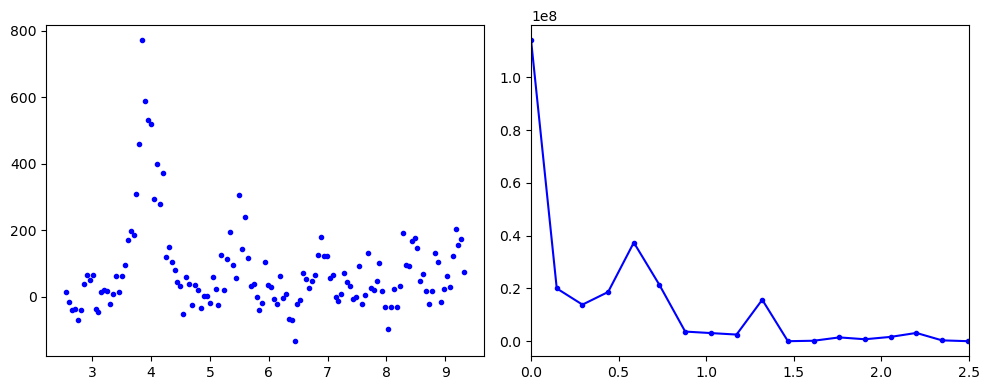

In [398]:
fig, axes = plt.subplots(ncols=2, nrows=1)
fig.set_figwidth(10)
fig.set_figheight(4)

axes[0].plot(delay_scan_t, delay_scan_I, c='b', marker='.', linestyle='')
axes[1].plot(delay_scan_ft, delay_scan_fI, c='b', marker='.', )
axes[1].set_xlim([0, 2.5])

plt.tight_layout()
plt.show()

In [399]:
def get_temporal_domain_dynamics(a1, eta1, a2, eta2, a3, time_array, field_holder, idx=29, phase_initial=np.pi / 2.):
    # Create a holder for the output pulse
    output_pulse_tot = np.zeros((time_array.shape[0]))
    output_pulse_tg = np.zeros((time_array.shape[0]))

    # Loop through all times
    for time_idx in range(time_array.shape[0]):
        time_val = time_array[time_idx]
        omega = np.mean(field_holder['omega'][:, :, :, :, idx], axis=1) / 0.75 * 0.59 * np.pi * 2  #* 1e6

        # Get the phase
        phase = np.exp(1.j * omega * time_val + 1.j * phase_initial)

        reflect_tot = np.sum((
                (np.square(np.real(
                    (field_holder['R0H'][:, :, :, idx] * a1 * np.exp(- eta1 * time_val) +
                     field_holder['d_plus'][:, :, :, idx] * phase +
                     field_holder['d_minus'][:, :, :, idx] * np.conjugate(phase))) * np.exp(- eta2 * time_val))) /
                np.abs(field_holder['b'][:, :, :, idx])),
            axis=(0, 1, 2))

        reflect_tg = np.sum((np.square(np.real(
            0 * field_holder['R0H'][:, :, :, idx] +
            1 * field_holder['d_plus'][:, :, :, idx] +
            0 * field_holder['d_minus'][:, :, :, idx])) /
                             np.abs(field_holder['b'][:, :, :, idx])),
                            axis=(0, 1, 2))

        output_pulse_tot[time_idx] = reflect_tot
        output_pulse_tg[time_idx] = reflect_tg

    return output_pulse_tot, output_pulse_tg

In [400]:
def get_temporal_domain_dynamics(a1, eta1, eta2, time_array, field_holder, omega, phase_initial=np.pi / 2.,
                                 ):
    field1 = np.abs(field_holder['d_plus'][16, 8, 8, 29]) * a1 * np.exp(- eta1 * time_array)
    phase = np.exp(1.j * omega * time_array + 1.j * phase_initial)
    field2 = (field_holder['d_plus'][16, 8, 8, 29] * phase +
              field_holder['d_minus'][16, 8, 8, 29] * np.conjugate(phase))
    
    output = (field1 + field2) * np.exp(- eta2 * time_array)
    output = np.square(np.real(output))
    
    return output

In [441]:
def plot_tmp(delay_scan_ft2, delay_scan_fI2):
    # -----------------------------------------------------
    fig, axes = plt.subplots(ncols=2, nrows=1)
    fig.set_figwidth(10)
    fig.set_figheight(4)

    axes_twin = axes[0].twinx()
    axes[0].plot(delay_scan_t, delay_scan_I * scaling + 1e-8, c='b', marker='.', linestyle='')
    #axes_twin.plot(time_scan / 1000 + 3.7, pulse_tot, c='r', marker='', linestyle='-')
    axes[0].plot(time_scan / 1000 + 3.2, pulse_tot, c='r', marker='', linestyle='-')
    axes[0].set_ylim([0, 3.5e-8])

    axes[1].plot(delay_scan_ft, delay_scan_fI, c='b', marker='.', )
    axes[1].plot(delay_scan_ft2, delay_scan_fI2 / delay_scan_fI2.max() * np.max(delay_scan_fI), c='r', marker='', linestyle='-')
    axes[1].set_xlim([0, 2.5])

    plt.tight_layout()
    plt.show()

0.00


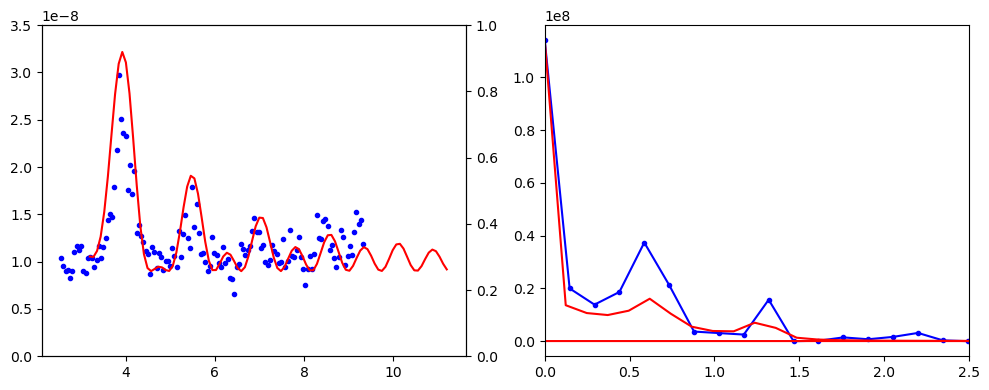

In [443]:
time_scan = np.linspace(start=0, stop=8e3, num=100)
idx = np.argmax(reflectivity_phonon_tg)

tic = time.time()
pulse_tot = get_temporal_domain_dynamics(
    a1=1.5, eta1=5e-4, eta2=6e-5,
    time_array=time_scan, field_holder=raw_data_tg, phase_initial=-2.161724345839325 + np.pi, omega=0.00065 * np.pi * 2)
toc = time.time()
print("{:.2f}".format(toc - tic))

# Match the peak and the bottom
pulse_tot -= np.min(pulse_tot)
scale1 = (np.max(delay_scan_I * scaling) - np.min(delay_scan_I * scaling)) / np.max(pulse_tot)
pulse_tot *= scale1
pulse_tot += 0.9e-8

delay_scan_ft2 = np.fft.fftfreq(n=100, d=(time_scan[1] - time_scan[0]))
delay_scan_fI2 = np.fft.fft(pulse_tot)

plot_tmp(delay_scan_ft2 * 1000, np.abs(delay_scan_fI2))

In [418]:
delay_scan_ft2 * 1000

array([ 0.     ,  0.12375,  0.2475 ,  0.37125,  0.495  ,  0.61875,
        0.7425 ,  0.86625,  0.99   ,  1.11375,  1.2375 ,  1.36125,
        1.485  ,  1.60875,  1.7325 ,  1.85625,  1.98   ,  2.10375,
        2.2275 ,  2.35125,  2.475  ,  2.59875,  2.7225 ,  2.84625,
        2.97   ,  3.09375,  3.2175 ,  3.34125,  3.465  ,  3.58875,
        3.7125 ,  3.83625,  3.96   ,  4.08375,  4.2075 ,  4.33125,
        4.455  ,  4.57875,  4.7025 ,  4.82625,  4.95   ,  5.07375,
        5.1975 ,  5.32125,  5.445  ,  5.56875,  5.6925 ,  5.81625,
        5.94   ,  6.06375, -6.1875 , -6.06375, -5.94   , -5.81625,
       -5.6925 , -5.56875, -5.445  , -5.32125, -5.1975 , -5.07375,
       -4.95   , -4.82625, -4.7025 , -4.57875, -4.455  , -4.33125,
       -4.2075 , -4.08375, -3.96   , -3.83625, -3.7125 , -3.58875,
       -3.465  , -3.34125, -3.2175 , -3.09375, -2.97   , -2.84625,
       -2.7225 , -2.59875, -2.475  , -2.35125, -2.2275 , -2.10375,
       -1.98   , -1.85625, -1.7325 , -1.60875, -1.485  , -1.36

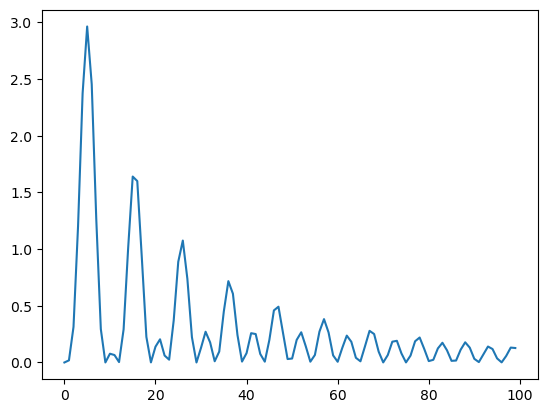

In [256]:
plt.plot((np.exp(-5e-4 * time_scan) + np.cos(time_scan * 0.0075 + np.pi)) ** 2 * np.exp(-2.5e-4 * time_scan))

In [295]:
np.rad2deg(np.angle(raw_data_tg['d_plus'][16, 8, 8, 29]))

123.85768148727209

In [297]:
np.angle(raw_data_tg['d_plus'][16, 8, 8, 29])

2.161724345839325

In [304]:
np.angle(raw_data_tg['R0H'][16, 8, 8, 29])

3.082797916574895

In [299]:
raw_data_tg['d_plus'][16, 8, 8, 29]


(-7.764456285594078e-06+1.1573185394128762e-05j)

In [308]:
raw_data_tg['d_minus'][16, 8, 8, 29]

(3.4194985373977474e-09+1.925095724016955e-08j)

In [309]:
1 / (np.abs(raw_data_tg['R0H'][16, 8, 8, 29]) / np.abs(raw_data_tg['d_minus'][16, 8, 8, 29]))


0.00014573395756711146